In [1]:
from typing import Callable, List, Optional, Tuple
import logging
from functools import partial
from typing import Any, Dict, List, Literal, Optional, Sequence, Tuple, Union
import math
import torch
import torch.nn.init
from torch import Tensor, nn
import torch.nn.functional as F

def cat_keep_shapes(x_list: List[Tensor]) -> Tuple[Tensor, List[Tuple[int]], List[int]]:
    shapes = [x.shape for x in x_list]
    num_tokens = [x.select(dim=-1, index=0).numel() for x in x_list]
    flattened = torch.cat([x.flatten(0, -2) for x in x_list])
    return flattened, shapes, num_tokens


def uncat_with_shapes(flattened: Tensor, shapes: List[Tuple[int]], num_tokens: List[int]) -> List[Tensor]:
    outputs_splitted = torch.split_with_sizes(flattened, num_tokens, dim=0)
    shapes_adjusted = [shape[:-1] + torch.Size([flattened.shape[-1]]) for shape in shapes]
    outputs_reshaped = [o.reshape(shape) for o, shape in zip(outputs_splitted, shapes_adjusted)]
    return outputs_reshaped

class ListForwardMixin(object):
    def forward(self, x: Tensor):
        raise NotImplementedError

    def forward_list(self, x_list: List[Tensor]) -> List[Tensor]:
        x_flat, shapes, num_tokens = cat_keep_shapes(x_list)
        x_flat = self.forward(x_flat)
        return uncat_with_shapes(x_flat, shapes, num_tokens)


class Mlp(nn.Module, ListForwardMixin):
    def __init__(
        self,
        in_features: int,
        hidden_features: Optional[int] = None,
        out_features: Optional[int] = None,
        act_layer: Callable[..., nn.Module] = nn.GELU,
        drop: float = 0.0,
        bias: bool = True,
        device=None,
    ) -> None:
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features, bias=bias, device=device)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features, bias=bias, device=device)
        self.drop = nn.Dropout(drop)

    def forward(self, x: Tensor) -> Tensor:
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class SwiGLUFFN(nn.Module, ListForwardMixin):
    def __init__(
        self,
        in_features: int,
        hidden_features: Optional[int] = None,
        out_features: Optional[int] = None,
        act_layer: Optional[Callable[..., nn.Module]] = None,
        drop: float = 0.0,
        bias: bool = True,
        align_to: int = 8,
        device=None,
    ) -> None:
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        d = int(hidden_features * 2 / 3)
        swiglu_hidden_features = d + (-d % align_to)
        self.w1 = nn.Linear(in_features, swiglu_hidden_features, bias=bias, device=device)
        self.w2 = nn.Linear(in_features, swiglu_hidden_features, bias=bias, device=device)
        self.w3 = nn.Linear(swiglu_hidden_features, out_features, bias=bias, device=device)

    def forward(self, x: Tensor) -> Tensor:
        x1 = self.w1(x)
        x2 = self.w2(x)
        hidden = F.silu(x1) * x2
        return self.w3(hidden)

def named_apply(
    fn: Callable,
    module: nn.Module,
    name: str = "",
    depth_first: bool = True,
    include_root: bool = False,
) -> nn.Module:
    if not depth_first and include_root:
        fn(module=module, name=name)
    for child_name, child_module in module.named_children():
        child_name = ".".join((name, child_name)) if name else child_name
        named_apply(
            fn=fn,
            module=child_module,
            name=child_name,
            depth_first=depth_first,
            include_root=True,
        )
    if depth_first and include_root:
        fn(module=module, name=name)
    return module

class LayerScale(nn.Module):
    def __init__(
        self,
        dim: int,
        init_values: Union[float, Tensor] = 1e-5,
        inplace: bool = False,
        device=None,
    ) -> None:
        super().__init__()
        self.inplace = inplace
        self.gamma = nn.Parameter(torch.empty(dim, device=device))
        self.init_values = init_values

    def reset_parameters(self):
        nn.init.constant_(self.gamma, self.init_values)

    def forward(self, x: Tensor) -> Tensor:
        return x.mul_(self.gamma) if self.inplace else x * self.gamma
    
def make_2tuple(x):
    if isinstance(x, tuple):
        assert len(x) == 2
        return x

    assert isinstance(x, int)
    return (x, x)


class PatchEmbed(nn.Module):
    """
    2D image to patch embedding: (B,C,H,W) -> (B,N,D)

    Args:
        img_size: Image size.
        patch_size: Patch token size.
        in_chans: Number of input image channels.
        embed_dim: Number of linear projection output channels.
        norm_layer: Normalization layer.
    """

    def __init__(
        self,
        img_size: Union[int, Tuple[int, int]] = 224,
        patch_size: Union[int, Tuple[int, int]] = 16,
        in_chans: int = 3,
        embed_dim: int = 768,
        norm_layer: Callable | None = None,
        flatten_embedding: bool = True,
    ) -> None:
        super().__init__()

        image_HW = make_2tuple(img_size)
        patch_HW = make_2tuple(patch_size)
        patch_grid_size = (
            image_HW[0] // patch_HW[0],
            image_HW[1] // patch_HW[1],
        )

        self.img_size = image_HW
        self.patch_size = patch_HW
        self.patches_resolution = patch_grid_size
        self.num_patches = patch_grid_size[0] * patch_grid_size[1]

        self.in_chans = in_chans
        self.embed_dim = embed_dim

        self.flatten_embedding = flatten_embedding

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_HW, stride=patch_HW)
        self.norm = norm_layer(embed_dim) if norm_layer else nn.Identity()

    def forward(self, x: Tensor) -> Tensor:
        _, _, H, W = x.shape
        # patch_H, patch_W = self.patch_size
        # assert H % patch_H == 0, f"Input image height {H} is not a multiple of patch height {patch_H}"
        # assert W % patch_W == 0, f"Input image width {W} is not a multiple of patch width: {patch_W}"

        x = self.proj(x)  # B C H W
        H, W = x.size(2), x.size(3)
        x = x.flatten(2).transpose(1, 2)  # B HW C
        x = self.norm(x)
        if not self.flatten_embedding:
            x = x.reshape(-1, H, W, self.embed_dim)  # B H W C
        return x

    def flops(self) -> float:
        Ho, Wo = self.patches_resolution
        flops = Ho * Wo * self.embed_dim * self.in_chans * (self.patch_size[0] * self.patch_size[1])
        if self.norm is not None:
            flops += Ho * Wo * self.embed_dim
        return flops

    def reset_parameters(self):
        k = 1 / (self.in_chans * (self.patch_size[0] ** 2))
        nn.init.uniform_(self.proj.weight, -math.sqrt(k), math.sqrt(k))
        if self.proj.bias is not None:
            nn.init.uniform_(self.proj.bias, -math.sqrt(k), math.sqrt(k))

class RMSNorm(nn.Module):
    def __init__(self, dim: int, eps: float = 1e-5):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(dim))
        self.eps = eps

    def reset_parameters(self) -> None:
        nn.init.constant_(self.weight, 1)

    def _norm(self, x: Tensor) -> Tensor:
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)

    def forward(self, x: Tensor) -> Tensor:
        output = self._norm(x.float()).type_as(x)
        return output * self.weight
    
class RopePositionEmbedding(nn.Module):
    def __init__(
        self,
        embed_dim: int,
        *,
        num_heads: int,
        base: float | None = 100.0,
        min_period: float | None = None,
        max_period: float | None = None,
        normalize_coords: Literal["min", "max", "separate"] = "separate",
        shift_coords: float | None = None,
        jitter_coords: float | None = None,
        rescale_coords: float | None = None,
        dtype: torch.dtype | None = None,
        device: torch.device | None = None,
    ):
        super().__init__()
        assert embed_dim % (4 * num_heads) == 0
        both_periods = min_period is not None and max_period is not None
        if (base is None and not both_periods) or (base is not None and both_periods):
            raise ValueError("Either `base` or `min_period`+`max_period` must be provided.")

        D_head = embed_dim // num_heads
        self.base = base
        self.min_period = min_period
        self.max_period = max_period
        self.D_head = D_head
        self.normalize_coords = normalize_coords
        self.shift_coords = shift_coords
        self.jitter_coords = jitter_coords
        self.rescale_coords = rescale_coords

        # Needs persistent=True because we do teacher.load_state_dict(student.state_dict()) to initialize the teacher
        self.dtype = dtype  # Don't rely on self.periods.dtype
        self.register_buffer(
            "periods",
            torch.empty(D_head // 4, device=device, dtype=dtype),
            persistent=True,
        )
        self._init_weights()

    def forward(self, *, H: int, W: int) -> tuple[Tensor, Tensor]:
        device = self.periods.device
        dtype = self.dtype
        dd = {"device": device, "dtype": dtype}

        # Prepare coords in range [-1, +1]
        if self.normalize_coords == "max":
            max_HW = max(H, W)
            coords_h = torch.arange(0.5, H, **dd) / max_HW  # [H]
            coords_w = torch.arange(0.5, W, **dd) / max_HW  # [W]
        elif self.normalize_coords == "min":
            min_HW = min(H, W)
            coords_h = torch.arange(0.5, H, **dd) / min_HW  # [H]
            coords_w = torch.arange(0.5, W, **dd) / min_HW  # [W]
        elif self.normalize_coords == "separate":
            coords_h = torch.arange(0.5, H, **dd) / H  # [H]
            coords_w = torch.arange(0.5, W, **dd) / W  # [W]
        else:
            raise ValueError(f"Unknown normalize_coords: {self.normalize_coords}")
        coords = torch.stack(torch.meshgrid(coords_h, coords_w, indexing="ij"), dim=-1)  # [H, W, 2]
        coords = coords.flatten(0, 1)  # [HW, 2]
        coords = 2.0 * coords - 1.0  # Shift range [0, 1] to [-1, +1]

        # Shift coords by adding a uniform value in [-shift, shift]
        if self.training and self.shift_coords is not None:
            shift_hw = torch.empty(2, **dd).uniform_(-self.shift_coords, self.shift_coords)
            coords += shift_hw[None, :]

        # Jitter coords by multiplying the range [-1, 1] by a log-uniform value in [1/jitter, jitter]
        if self.training and self.jitter_coords is not None:
            jitter_max = np.log(self.jitter_coords)
            jitter_min = -jitter_max
            jitter_hw = torch.empty(2, **dd).uniform_(jitter_min, jitter_max).exp()
            coords *= jitter_hw[None, :]

        # Rescale coords by multiplying the range [-1, 1] by a log-uniform value in [1/rescale, rescale]
        if self.training and self.rescale_coords is not None:
            rescale_max = np.log(self.rescale_coords)
            rescale_min = -rescale_max
            rescale_hw = torch.empty(1, **dd).uniform_(rescale_min, rescale_max).exp()
            coords *= rescale_hw

        # Prepare angles and sin/cos
        angles = 2 * math.pi * coords[:, :, None] / self.periods[None, None, :]  # [HW, 2, D//4]
        angles = angles.flatten(1, 2)  # [HW, D//2]
        angles = angles.tile(2)  # [HW, D]
        cos = torch.cos(angles)  # [HW, D]
        sin = torch.sin(angles)  # [HW, D]

        return (sin, cos)  # 2 * [HW, D]

    def _init_weights(self):
        device = self.periods.device
        dtype = self.dtype
        if self.base is not None:
            periods = self.base ** (
                2 * torch.arange(self.D_head // 4, device=device, dtype=dtype) / (self.D_head // 2)
            )  # [D//4]
        else:
            base = self.max_period / self.min_period
            exponents = torch.linspace(0, 1, self.D_head // 4, device=device, dtype=dtype)  # [D//4] range [0, 1]
            periods = base**exponents  # range [1, max_period / min_period]
            periods = periods / base  # range [min_period / max_period, 1]
            periods = periods * self.max_period  # range [min_period, max_period]
        self.periods.data = periods


def rope_rotate_half(x: Tensor) -> Tensor:
    # x:   [ x0  x1  x2  x3  x4  x5]
    # out: [-x3 -x4 -x5  x0  x1  x2]
    x1, x2 = x.chunk(2, dim=-1)
    return torch.cat([-x2, x1], dim=-1)


def rope_apply(x: Tensor, sin: Tensor, cos: Tensor) -> Tensor:
    # x:   [..., D], eg [x0,     x1,   x2,   x3,   x4,   x5]
    # sin: [..., D], eg [sin0, sin1, sin2, sin0, sin1, sin2]
    # cos: [..., D], eg [cos0, cos1, cos2, cos0, cos1, cos2]
    return (x * cos) + (rope_rotate_half(x) * sin)


class LinearKMaskedBias(nn.Linear):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        o = self.out_features
        assert o % 3 == 0
        if self.bias is not None:
            self.register_buffer("bias_mask", torch.full_like(self.bias, fill_value=math.nan))

    def forward(self, input: Tensor) -> Tensor:
        masked_bias = self.bias * self.bias_mask.to(self.bias.dtype) if self.bias is not None else None
        return F.linear(input, self.weight, masked_bias)


class SelfAttention(nn.Module):
    def __init__(
        self,
        dim: int,
        num_heads: int = 8,
        qkv_bias: bool = False,
        proj_bias: bool = True,
        attn_drop: float = 0.0,
        proj_drop: float = 0.0,
        mask_k_bias: bool = False,
        device=None,
    ) -> None:
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim**-0.5

        linear_class = LinearKMaskedBias if mask_k_bias else nn.Linear
        self.qkv = linear_class(dim, dim * 3, bias=qkv_bias, device=device)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim, bias=proj_bias, device=device)
        self.proj_drop = nn.Dropout(proj_drop)

    def apply_rope(self, q: Tensor, k: Tensor, rope: Tensor | Tuple[Tensor, Tensor]) -> Tuple[Tensor, Tensor]:
        # All operations will use the dtype of rope, the output is cast back to the dtype of q and k
        q_dtype = q.dtype
        k_dtype = k.dtype
        sin, cos = rope
        rope_dtype = sin.dtype
        q = q.to(dtype=rope_dtype)
        k = k.to(dtype=rope_dtype)
        N = q.shape[-2]
        prefix = N - sin.shape[-2]
        assert prefix >= 0
        q_prefix = q[:, :, :prefix, :]
        q = rope_apply(q[:, :, prefix:, :], sin, cos)  # [B, head, hw, D//head]
        q = torch.cat((q_prefix, q), dim=-2)  # [B, head, N, D//head]
        k_prefix = k[:, :, :prefix, :]
        k = rope_apply(k[:, :, prefix:, :], sin, cos)  # [B, head, hw, D//head]
        k = torch.cat((k_prefix, k), dim=-2)  # [B, head, N, D//head]
        q = q.to(dtype=q_dtype)
        k = k.to(dtype=k_dtype)
        return q, k

    def forward(self, x: Tensor, attn_bias=None, rope: Tensor = None) -> Tensor:
        qkv = self.qkv(x)
        attn_v = self.compute_attention(qkv=qkv, attn_bias=attn_bias, rope=rope)
        x = self.proj(attn_v)
        x = self.proj_drop(x)
        return x

    def forward_list(self, x_list, attn_bias=None, rope_list=None) -> List[Tensor]:
        assert len(x_list) == len(rope_list)  # should be enforced by the Block
        x_flat, shapes, num_tokens = cat_keep_shapes(x_list)
        qkv_flat = self.qkv(x_flat)
        qkv_list = uncat_with_shapes(qkv_flat, shapes, num_tokens)
        att_out = []
        for _, (qkv, _, rope) in enumerate(zip(qkv_list, shapes, rope_list)):
            att_out.append(self.compute_attention(qkv, attn_bias=attn_bias, rope=rope))
        x_flat, shapes, num_tokens = cat_keep_shapes(att_out)
        x_flat = self.proj(x_flat)
        return uncat_with_shapes(x_flat, shapes, num_tokens)

    def compute_attention(self, qkv: Tensor, attn_bias=None, rope=None) -> Tensor:
        assert attn_bias is None
        B, N, _ = qkv.shape
        C = self.qkv.in_features

        qkv = qkv.reshape(B, N, 3, self.num_heads, C // self.num_heads)
        q, k, v = torch.unbind(qkv, 2)
        q, k, v = [t.transpose(1, 2) for t in [q, k, v]]
        if rope is not None:
            q, k = self.apply_rope(q, k, rope)
        x = torch.nn.functional.scaled_dot_product_attention(q, k, v)
        x = x.transpose(1, 2)
        return x.reshape([B, N, C])



class SelfAttentionBlock(nn.Module):
    def __init__(
        self,
        dim: int,
        num_heads: int,
        ffn_ratio: float = 4.0,
        qkv_bias: bool = False,
        proj_bias: bool = True,
        ffn_bias: bool = True,
        drop: float = 0.0,
        attn_drop: float = 0.0,
        init_values=None,
        drop_path: float = 0.0,
        act_layer: Callable[..., nn.Module] = nn.GELU,
        norm_layer: Callable[..., nn.Module] = nn.LayerNorm,
        attn_class: Callable[..., nn.Module] = SelfAttention,
        ffn_layer: Callable[..., nn.Module] = Mlp,
        mask_k_bias: bool = False,
        device=None,
    ) -> None:
        super().__init__()
        # print(f"biases: qkv: {qkv_bias}, proj: {proj_bias}, ffn: {ffn_bias}")
        self.norm1 = norm_layer(dim)
        self.attn = attn_class(
            dim,
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            proj_bias=proj_bias,
            attn_drop=attn_drop,
            proj_drop=drop,
            mask_k_bias=mask_k_bias,
            device=device,
        )
        self.ls1 = LayerScale(dim, init_values=init_values, device=device) if init_values else nn.Identity()

        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * ffn_ratio)
        self.mlp = ffn_layer(
            in_features=dim,
            hidden_features=mlp_hidden_dim,
            act_layer=act_layer,
            drop=drop,
            bias=ffn_bias,
            device=device,
        )
        self.ls2 = LayerScale(dim, init_values=init_values, device=device) if init_values else nn.Identity()

        self.sample_drop_ratio = drop_path

    @staticmethod
    def _maybe_index_rope(rope: tuple[Tensor, Tensor] | None, indices: Tensor) -> tuple[Tensor, Tensor] | None:
        if rope is None:
            return None

        sin, cos = rope
        assert sin.ndim == cos.ndim
        if sin.ndim == 4:
            # If the rope embedding has a batch dimension (is different for each batch element), index into it
            return sin[indices], cos[indices]  # [batch, heads, patches, embed_dim]
        else:
            # No batch dimension, do not index
            return sin, cos  # [heads, patches, embed_dim] or [patches, embed_dim]

    def _forward(self, x: Tensor, rope=None) -> Tensor:
        """
        This is the reference implementation for a single tensor, matching what is done below for a list.
        We call the list op on [x] instead of this function.
        """
        b, _, _ = x.shape
        sample_subset_size = max(int(b * (1 - self.sample_drop_ratio)), 1)
        residual_scale_factor = b / sample_subset_size

        if self.training and self.sample_drop_ratio > 0.0:
            indices_1 = (torch.randperm(b, device=x.device))[:sample_subset_size]

            x_subset_1 = x[indices_1]
            rope_subset = self._maybe_index_rope(rope, indices_1)
            residual_1 = self.attn(self.norm1(x_subset_1), rope=rope_subset)

            x_attn = torch.index_add(
                x,
                dim=0,
                source=self.ls1(residual_1),
                index=indices_1,
                alpha=residual_scale_factor,
            )

            indices_2 = (torch.randperm(b, device=x.device))[:sample_subset_size]

            x_subset_2 = x_attn[indices_2]
            residual_2 = self.mlp(self.norm2(x_subset_2))

            x_ffn = torch.index_add(
                x_attn,
                dim=0,
                source=self.ls2(residual_2),
                index=indices_2,
                alpha=residual_scale_factor,
            )
        else:
            x_attn = x + self.ls1(self.attn(self.norm1(x), rope=rope))
            x_ffn = x_attn + self.ls2(self.mlp(self.norm2(x_attn)))

        return x_ffn

    def _forward_list(self, x_list: List[Tensor], rope_list=None) -> List[Tensor]:
        """
        This list operator concatenates the tokens from the list of inputs together to save
        on the elementwise operations. Torch-compile memory-planning allows hiding the overhead
        related to concat ops.
        """
        b_list = [x.shape[0] for x in x_list]
        sample_subset_sizes = [max(int(b * (1 - self.sample_drop_ratio)), 1) for b in b_list]
        residual_scale_factors = [b / sample_subset_size for b, sample_subset_size in zip(b_list, sample_subset_sizes)]

        if self.training and self.sample_drop_ratio > 0.0:
            indices_1_list = [
                (torch.randperm(b, device=x.device))[:sample_subset_size]
                for x, b, sample_subset_size in zip(x_list, b_list, sample_subset_sizes)
            ]
            x_subset_1_list = [x[indices_1] for x, indices_1 in zip(x_list, indices_1_list)]

            if rope_list is not None:
                rope_subset_list = [
                    self._maybe_index_rope(rope, indices_1) for rope, indices_1 in zip(rope_list, indices_1_list)
                ]
            else:
                rope_subset_list = rope_list

            flattened, shapes, num_tokens = cat_keep_shapes(x_subset_1_list)
            norm1 = uncat_with_shapes(self.norm1(flattened), shapes, num_tokens)
            residual_1_list = self.attn.forward_list(norm1, rope_list=rope_subset_list)

            x_attn_list = [
                torch.index_add(
                    x,
                    dim=0,
                    source=self.ls1(residual_1),
                    index=indices_1,
                    alpha=residual_scale_factor,
                )
                for x, residual_1, indices_1, residual_scale_factor in zip(
                    x_list, residual_1_list, indices_1_list, residual_scale_factors
                )
            ]

            indices_2_list = [
                (torch.randperm(b, device=x.device))[:sample_subset_size]
                for x, b, sample_subset_size in zip(x_list, b_list, sample_subset_sizes)
            ]
            x_subset_2_list = [x[indices_2] for x, indices_2 in zip(x_attn_list, indices_2_list)]
            flattened, shapes, num_tokens = cat_keep_shapes(x_subset_2_list)
            norm2_flat = self.norm2(flattened)
            norm2_list = uncat_with_shapes(norm2_flat, shapes, num_tokens)

            residual_2_list = self.mlp.forward_list(norm2_list)

            x_ffn = [
                torch.index_add(
                    x_attn,
                    dim=0,
                    source=self.ls2(residual_2),
                    index=indices_2,
                    alpha=residual_scale_factor,
                )
                for x_attn, residual_2, indices_2, residual_scale_factor in zip(
                    x_attn_list, residual_2_list, indices_2_list, residual_scale_factors
                )
            ]
        else:
            x_out = []
            for x, rope in zip(x_list, rope_list):
                x_attn = x + self.ls1(self.attn(self.norm1(x), rope=rope))
                x_ffn = x_attn + self.ls2(self.mlp(self.norm2(x_attn)))
                x_out.append(x_ffn)
            x_ffn = x_out

        return x_ffn

    def forward(self, x_or_x_list, rope_or_rope_list=None) -> List[Tensor]:
        if isinstance(x_or_x_list, Tensor):
            # for reference:
            # return self._forward(x_or_x_list, rope=rope_or_rope_list)
            # in order to match implementations we call the list op:
            return self._forward_list([x_or_x_list], rope_list=[rope_or_rope_list])[0]
        elif isinstance(x_or_x_list, list):
            if rope_or_rope_list is None:
                rope_or_rope_list = [None for x in x_or_x_list]
            # return [self._forward(x, rope=rope) for x, rope in zip(x_or_x_list, rope_or_rope_list)]
            return self._forward_list(x_or_x_list, rope_list=rope_or_rope_list)
        else:
            raise AssertionError

In [ ]:
logger = logging.getLogger("dinov3")

ffn_layer_dict = {
    "mlp": Mlp,
    "swiglu": SwiGLUFFN,
    "swiglu32": partial(SwiGLUFFN, align_to=32),
    "swiglu64": partial(SwiGLUFFN, align_to=64),
    "swiglu128": partial(SwiGLUFFN, align_to=128),
}

norm_layer_dict = {
    "layernorm": partial(nn.LayerNorm, eps=1e-6),
    "layernormbf16": partial(nn.LayerNorm, eps=1e-5),
    "rmsnorm": RMSNorm,
}

dtype_dict = {
    "fp32": torch.float32,
    "fp16": torch.float16,
    "bf16": torch.bfloat16,
}


def init_weights_vit(module: nn.Module, name: str = ""):
    if isinstance(module, nn.Linear):
        torch.nn.init.trunc_normal_(module.weight, std=0.02)
        if module.bias is not None:
            nn.init.zeros_(module.bias)
        if hasattr(module, "bias_mask") and module.bias_mask is not None:
            o = module.out_features
            module.bias_mask.fill_(1)
            module.bias_mask[o // 3 : 2 * o // 3].fill_(0)
    if isinstance(module, nn.LayerNorm):
        module.reset_parameters()
    if isinstance(module, LayerScale):
        module.reset_parameters()
    if isinstance(module, PatchEmbed):
        module.reset_parameters()
    if isinstance(module, RMSNorm):
        module.reset_parameters()


class DinoVisionTransformer(nn.Module):
    def __init__(
        self,
        *,
        img_size: int = 224,
        patch_size: int = 16,
        in_chans: int = 3,
        pos_embed_rope_base: float = 100.0,
        pos_embed_rope_min_period: float | None = None,
        pos_embed_rope_max_period: float | None = None,
        pos_embed_rope_normalize_coords: Literal["min", "max", "separate"] = "separate",
        pos_embed_rope_shift_coords: float | None = None,
        pos_embed_rope_jitter_coords: float | None = None,
        pos_embed_rope_rescale_coords: float | None = None,
        pos_embed_rope_dtype: str = "bf16",
        embed_dim: int = 768,
        depth: int = 12,
        num_heads: int = 12,
        ffn_ratio: float = 4.0,
        qkv_bias: bool = True,
        drop_path_rate: float = 0.0,
        layerscale_init: float | None = None,
        norm_layer: str = "layernorm",
        ffn_layer: str = "mlp",
        ffn_bias: bool = True,
        proj_bias: bool = True,
        n_storage_tokens: int = 0,
        mask_k_bias: bool = False,
        untie_cls_and_patch_norms: bool = False,
        untie_global_and_local_cls_norm: bool = False,
        device: Any | None = None,
        **ignored_kwargs,
    ):
        super().__init__()
        if len(ignored_kwargs) > 0:
            logger.warning(f"Ignored kwargs: {ignored_kwargs}")
        del ignored_kwargs

        norm_layer_cls = norm_layer_dict[norm_layer]

        self.num_features = self.embed_dim = embed_dim  # num_features for consistency with other models
        self.n_blocks = depth
        self.num_heads = num_heads
        self.patch_size = patch_size

        self.patch_embed = PatchEmbed(
            img_size=img_size,
            patch_size=patch_size,
            in_chans=in_chans,
            embed_dim=embed_dim,
            flatten_embedding=False,
        )

        self.cls_token = nn.Parameter(torch.empty(1, 1, embed_dim, device=device))
        self.n_storage_tokens = n_storage_tokens
        if self.n_storage_tokens > 0:
            self.storage_tokens = nn.Parameter(torch.empty(1, n_storage_tokens, embed_dim, device=device))
        logger.info(f"using base={pos_embed_rope_base} for rope new")
        logger.info(f"using min_period={pos_embed_rope_min_period} for rope new")
        logger.info(f"using max_period={pos_embed_rope_max_period} for rope new")
        logger.info(f"using normalize_coords={pos_embed_rope_normalize_coords} for rope new")
        logger.info(f"using shift_coords={pos_embed_rope_shift_coords} for rope new")
        logger.info(f"using rescale_coords={pos_embed_rope_rescale_coords} for rope new")
        logger.info(f"using jitter_coords={pos_embed_rope_jitter_coords} for rope new")
        logger.info(f"using dtype={pos_embed_rope_dtype} for rope new")
        self.rope_embed = RopePositionEmbedding(
            embed_dim=embed_dim,
            num_heads=num_heads,
            base=pos_embed_rope_base,
            min_period=pos_embed_rope_min_period,
            max_period=pos_embed_rope_max_period,
            normalize_coords=pos_embed_rope_normalize_coords,
            shift_coords=pos_embed_rope_shift_coords,
            jitter_coords=pos_embed_rope_jitter_coords,
            rescale_coords=pos_embed_rope_rescale_coords,
            dtype=dtype_dict[pos_embed_rope_dtype],
            device=device,
        )
        logger.info(f"using {ffn_layer} layer as FFN")
        ffn_layer_cls = ffn_layer_dict[ffn_layer]
        ffn_ratio_sequence = [ffn_ratio] * depth
        blocks_list = [
            SelfAttentionBlock(
                dim=embed_dim,
                num_heads=num_heads,
                ffn_ratio=ffn_ratio_sequence[i],
                qkv_bias=qkv_bias,
                proj_bias=proj_bias,
                ffn_bias=ffn_bias,
                drop_path=drop_path_rate,
                norm_layer=norm_layer_cls,
                act_layer=nn.GELU,
                ffn_layer=ffn_layer_cls,
                init_values=layerscale_init,
                mask_k_bias=mask_k_bias,
                device=device,
            )
            for i in range(depth)
        ]

        self.chunked_blocks = False
        self.blocks = nn.ModuleList(blocks_list)

        # This norm is applied to everything, or when untying, to patch and mask tokens.
        self.norm = norm_layer_cls(embed_dim)

        self.untie_cls_and_patch_norms = untie_cls_and_patch_norms
        if untie_cls_and_patch_norms:
            # When untying, this norm is applied to CLS tokens and registers.
            self.cls_norm = norm_layer_cls(embed_dim)
        else:
            self.cls_norm = None

        self.untie_global_and_local_cls_norm = untie_global_and_local_cls_norm
        if untie_global_and_local_cls_norm:
            # When untying, this norm is applied to local CLS tokens and registers.
            # This norm is never used during eval.
            self.local_cls_norm = norm_layer_cls(embed_dim)
        else:
            self.local_cls_norm = None
        self.head = nn.Identity()
        self.mask_token = nn.Parameter(torch.empty(1, embed_dim, device=device))

    def init_weights(self):
        self.rope_embed._init_weights()
        nn.init.normal_(self.cls_token, std=0.02)
        if self.n_storage_tokens > 0:
            nn.init.normal_(self.storage_tokens, std=0.02)
        nn.init.zeros_(self.mask_token)
        named_apply(init_weights_vit, self)

    def prepare_tokens_with_masks(self, x: Tensor, masks=None) -> Tuple[Tensor, Tuple[int]]:
        x = self.patch_embed(x)
        B, H, W, _ = x.shape
        x = x.flatten(1, 2)

        if masks is not None:
            x = torch.where(masks.unsqueeze(-1), self.mask_token.to(x.dtype).unsqueeze(0), x)
            cls_token = self.cls_token
        else:
            cls_token = self.cls_token + 0 * self.mask_token
        if self.n_storage_tokens > 0:
            storage_tokens = self.storage_tokens
        else:
            storage_tokens = torch.empty(
                1,
                0,
                cls_token.shape[-1],
                dtype=cls_token.dtype,
                device=cls_token.device,
            )

        x = torch.cat(
            [
                cls_token.expand(B, -1, -1),
                storage_tokens.expand(B, -1, -1),
                x,
            ],
            dim=1,
        )

        return x, (H, W)

    def forward_features_list(self, x_list: List[Tensor], masks_list: List[Tensor]) -> List[Dict[str, Tensor]]:
        x = []
        rope = []
        for t_x, t_masks in zip(x_list, masks_list):
            t2_x, hw_tuple = self.prepare_tokens_with_masks(t_x, t_masks)
            x.append(t2_x)
            rope.append(hw_tuple)
        for _, blk in enumerate(self.blocks):
            if self.rope_embed is not None:
                rope_sincos = [self.rope_embed(H=H, W=W) for H, W in rope]
            else:
                rope_sincos = [None for r in rope]
            x = blk(x, rope_sincos)
        all_x = x
        output = []
        for idx, (x, masks) in enumerate(zip(all_x, masks_list)):
            if self.untie_cls_and_patch_norms or self.untie_global_and_local_cls_norm:
                if self.untie_global_and_local_cls_norm and self.training and idx == 1:
                    # Assume second entry of list corresponds to local crops.
                    # We only ever apply this during training.
                    x_norm_cls_reg = self.local_cls_norm(x[:, : self.n_storage_tokens + 1])
                elif self.untie_cls_and_patch_norms:
                    x_norm_cls_reg = self.cls_norm(x[:, : self.n_storage_tokens + 1])
                else:
                    x_norm_cls_reg = self.norm(x[:, : self.n_storage_tokens + 1])
                x_norm_patch = self.norm(x[:, self.n_storage_tokens + 1 :])
            else:
                x_norm = self.norm(x)
                x_norm_cls_reg = x_norm[:, : self.n_storage_tokens + 1]
                x_norm_patch = x_norm[:, self.n_storage_tokens + 1 :]
            output.append(
                {
                    "x_norm_clstoken": x_norm_cls_reg[:, 0],
                    "x_storage_tokens": x_norm_cls_reg[:, 1:],
                    "x_norm_patchtokens": x_norm_patch,
                    "x_prenorm": x,
                    "masks": masks,
                }
            )
        return output

    def forward_features(self, x: Tensor | List[Tensor], masks: Optional[Tensor] = None) -> List[Dict[str, Tensor]]:
        if isinstance(x, torch.Tensor):
            return self.forward_features_list([x], [masks])[0]
        else:
            return self.forward_features_list(x, masks)

    def _get_intermediate_layers_not_chunked(self, x: Tensor, n: int = 1) -> List[Tensor]:
        x, (H, W) = self.prepare_tokens_with_masks(x)
        # If n is an int, take the n last blocks. If it's a list, take them
        output, total_block_len = [], len(self.blocks)
        blocks_to_take = range(total_block_len - n, total_block_len) if isinstance(n, int) else n
        for i, blk in enumerate(self.blocks):
            if self.rope_embed is not None:
                rope_sincos = self.rope_embed(H=H, W=W)
            else:
                rope_sincos = None
            x = blk(x, rope_sincos)
            if i in blocks_to_take:
                output.append(x)
        assert len(output) == len(blocks_to_take), f"only {len(output)} / {len(blocks_to_take)} blocks found"
        return output

    def get_intermediate_layers(
        self,
        x: torch.Tensor,
        *,
        n: Union[int, Sequence] = 1,  # Layers or n last layers to take
        reshape: bool = False,
        return_class_token: bool = False,
        return_extra_tokens: bool = False,
        norm: bool = True,
    ) -> Tuple[Union[torch.Tensor, Tuple[torch.Tensor, ...]]]:
        outputs = self._get_intermediate_layers_not_chunked(x, n)
        if norm:
            outputs_normed = []
            for out in outputs:
                if self.untie_cls_and_patch_norms:
                    x_norm_cls_reg = self.cls_norm(out[:, : self.n_storage_tokens + 1])
                    x_norm_patch = self.norm(out[:, self.n_storage_tokens + 1 :])
                    outputs_normed.append(torch.cat((x_norm_cls_reg, x_norm_patch), dim=1))
                else:
                    outputs_normed.append(self.norm(out))
            outputs = outputs_normed
        class_tokens = [out[:, 0] for out in outputs]
        extra_tokens = [out[:, 1 : self.n_storage_tokens + 1] for out in outputs]
        outputs = [out[:, self.n_storage_tokens + 1 :] for out in outputs]
        if reshape:
            B, _, h, w = x.shape
            outputs = [
                out.reshape(B, h // self.patch_size, w // self.patch_size, -1).permute(0, 3, 1, 2).contiguous()
                for out in outputs
            ]
        if not return_class_token and not return_extra_tokens:
            return tuple(outputs)
        elif return_class_token and not return_extra_tokens:
            return tuple(zip(outputs, class_tokens))
        elif not return_class_token and return_extra_tokens:
            return tuple(zip(outputs, extra_tokens))
        elif return_class_token and return_extra_tokens:
            return tuple(zip(outputs, class_tokens, extra_tokens))

    def forward(self, *args, is_training: bool = False, **kwargs) -> List[Dict[str, Tensor]] | Tensor:
        ret = self.forward_features(*args, **kwargs)
        if is_training:
            return ret
        else:
            return self.head(ret["x_norm_clstoken"])

# https://github.com/facebookresearch/dinov3/blob/main/dinov3/hub/backbones.py
def vit_small(**kwargs):
    model = DinoVisionTransformer(
        img_size=224,
        patch_size=16,
        in_chans=3,
        pos_embed_rope_base=100,
        pos_embed_rope_normalize_coords="separate",
        pos_embed_rope_rescale_coords=2,
        pos_embed_rope_dtype="fp32",
        embed_dim=384,
        depth=12,
        num_heads=6,
        ffn_ratio=4,
        qkv_bias=True,
        drop_path_rate=0.0,
        layerscale_init=1.0e-05,
        norm_layer="layernormbf16",
        ffn_layer="mlp",
        ffn_bias=True,
        proj_bias=True,
        n_storage_tokens=4,
        mask_k_bias=True,
        compact_arch_name="vits",
        **kwargs,
    )
    return model

In [ ]:
model = vit_small()

state_dict = torch.load("/Users/saptarshimallikthakur/Downloads/dinov3_vits16_pretrain_lvd1689m-08c60483.pth", map_location="cpu")
model.load_state_dict(state_dict)
model.eval()               

DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (rope_embed): RopePositionEmbedding()
  (blocks): ModuleList(
    (0-11): 12 x SelfAttentionBlock(
      (norm1): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
      (attn): SelfAttention(
        (qkv): LinearKMaskedBias(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (norm2): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
    )
  )
  (norm): LayerN

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from PIL import Image
from torchvision import transforms

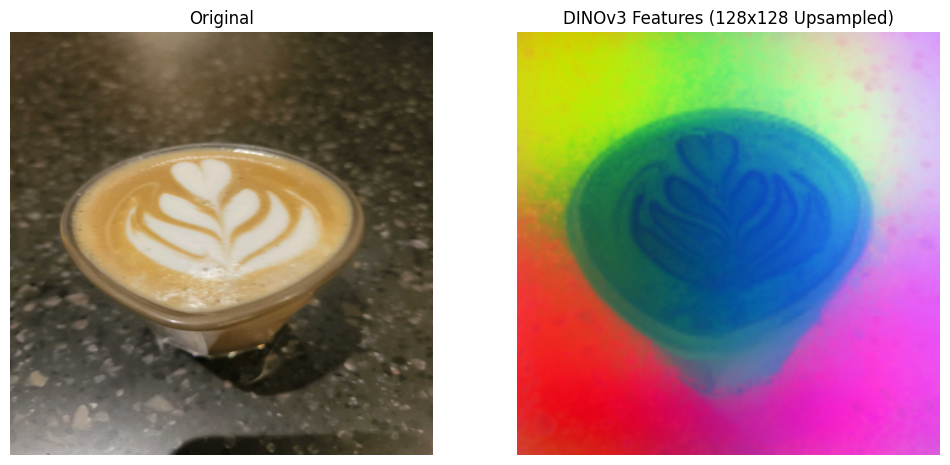

In [28]:
# 1. Setup
IMG_SIZE = 2048
transform_high_res = transforms.Compose([
    transforms.Resize(IMG_SIZE, interpolation=3),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 2. Load
img_path = "/Users/saptarshimallikthakur/Pictures/VLM/sharan_startup/Latte Art-Nymbleup/2025-06-02/Cortado/alwarpet_store_Cortado.jpg" 
raw_image = Image.open(img_path).convert('RGB')
x = transform_high_res(raw_image).unsqueeze(0)

# 3. Inference
with torch.no_grad():
    # CORRECTED LINE: No [0] index here
    features_dict = model.forward_features(x)
    patch_tokens = features_dict['x_norm_patchtokens'][0].cpu()

# 4. Grid Calc
h, w = x.shape[2] // 16, x.shape[3] // 16 

# 5. PCA
patch_tokens = patch_tokens / patch_tokens.norm(dim=-1, keepdim=True)
pca = PCA(n_components=3)
pca_features = pca.fit_transform(patch_tokens.numpy())
pca_features = (pca_features - pca_features.min(0)) / (pca_features.max(0) - pca_features.min(0))

# 6. Reshape & Upsample
feature_map = pca_features.reshape(h, w, 3)
feature_tensor = torch.from_numpy(feature_map).permute(2, 0, 1).unsqueeze(0)
upsampled_features = F.interpolate(
    feature_tensor, 
    size=(IMG_SIZE, IMG_SIZE), 
    mode='bilinear', 
    align_corners=False
).squeeze(0).permute(1, 2, 0).numpy()

# 7. Plot
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(raw_image.resize((IMG_SIZE, IMG_SIZE)))
ax[0].set_title("Original")
ax[0].axis('off')

ax[1].imshow(upsampled_features)
ax[1].set_title(f"DINOv3 Features ({h}x{w} Upsampled)")
ax[1].axis('off')

plt.show()

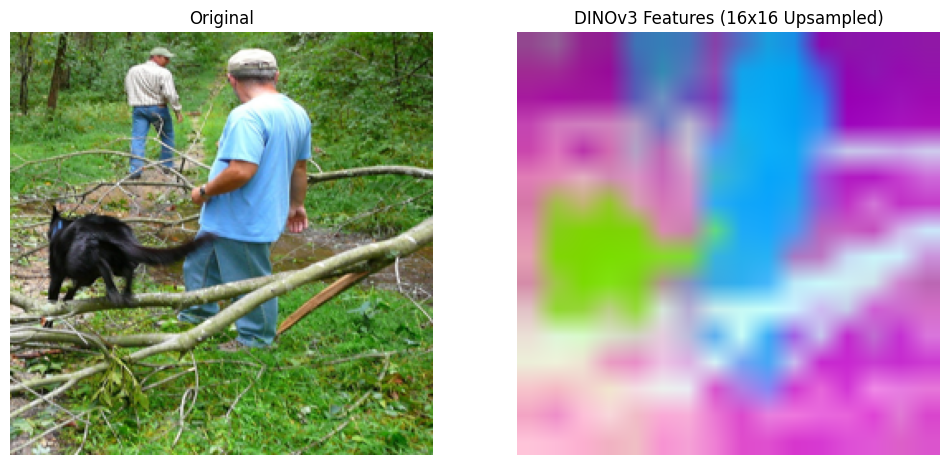

In [43]:
# 1. Setup
IMG_SIZE = 256
transform_high_res = transforms.Compose([
    transforms.Resize(IMG_SIZE, interpolation=3),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 2. Load
img_path = "/Users/saptarshimallikthakur/Pictures/vik_lnqa/train-00023-of-00199/0be3ae1c7aa72a6c.jpg" 
raw_image = Image.open(img_path).convert('RGB')
x = transform_high_res(raw_image).unsqueeze(0)

# 3. Inference
with torch.no_grad():
    # CORRECTED LINE: No [0] index here
    features_dict = model.forward_features(x)
    patch_tokens = features_dict['x_norm_patchtokens'][0].cpu()

# 4. Grid Calc
h, w = x.shape[2] // 16, x.shape[3] // 16 

# 5. PCA
patch_tokens = patch_tokens / patch_tokens.norm(dim=-1, keepdim=True)
pca = PCA(n_components=3)
pca_features = pca.fit_transform(patch_tokens.numpy())
pca_features = (pca_features - pca_features.min(0)) / (pca_features.max(0) - pca_features.min(0))

# 6. Reshape & Upsample
feature_map = pca_features.reshape(h, w, 3)
feature_tensor = torch.from_numpy(feature_map).permute(2, 0, 1).unsqueeze(0)
upsampled_features = F.interpolate(
    feature_tensor, 
    size=(IMG_SIZE, IMG_SIZE), 
    mode='bilinear', 
    align_corners=False
).squeeze(0).permute(1, 2, 0).numpy()

# 7. Plot
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(raw_image.resize((IMG_SIZE, IMG_SIZE)))
ax[0].set_title("Original")
ax[0].axis('off')

ax[1].imshow(upsampled_features)
ax[1].set_title(f"DINOv3 Features ({h}x{w} Upsampled)")
ax[1].axis('off')

plt.show()